# GMRES

## Ejemplos

In [1]:
import numpy as np
import scipy.linalg as spla
from scipy.sparse.linalg import gmres
import matplotlib.pyplot as plt

### Implementación $QR$ reducido

In [2]:
def QR(A, modified=True):
    m, n = A.shape
    Q = np.zeros((m, n))
    R = np.zeros((n, n))
    # Gram-Schmidt orthogonalization
    for j in range(n):
        y = A[:, j]
        if modified:
            for i in range(j):
                R[i, j] = np.dot(Q[:, i], y)
                y = y - R[i, j] * Q[:, i]
        else:
            for i in range(j):
                R[i, j] = np.dot(Q[:, i], A[:, j])
                y = y - R[i, j] * Q[:, i]
        R[j, j] = np.linalg.norm(y)
        Q[:, j] = y / R[j, j]
    return Q, R

### Mínimos Cuadrados

In [3]:
def lstsq(A, b, qr=True):
    if qr:
        Q, R = QR(A) # QR reduced
        x = spla.solve_triangular(R, np.dot(Q.T, b)) # Solve Rx=Q^*b
    else:
        x = np.linalg.solve(np.dot(A.T, A), np.dot(A.T, b)) # Solve A^*Ax=A^*b
    return x

### Implementación GMRES

Versión modificada de [1].

In [4]:
def GMRES(A, b, x_0=None, tol=1e-10, max_iter=100, show=False, np_ls=False):
    m = b.shape[0]
    
    M = np.min([m, max_iter])
    
    X = np.zeros((M + 1, m))
    if x_0 is not None:
        X[0] = x_0
    
    r_0 = b - np.dot(A, X[0])
    n_r0 = np.linalg.norm(r_0)
    
    Q = np.zeros((m, m))
    H = np.zeros((m, m))
    
    Q[:, 0] = r_0 / n_r0

    for k in range(M):
        
        # Arnoldi Iteration
        y = np.dot(A, Q[:, k])
        for j in np.arange(k+1):
            H[j, k] = np.dot(Q[:,j], y)
            y = y - H[j, k] * Q[:,j]
        
        # Build H matrix and fill Q_k
        if k + 1 < m: 
            H[k+1, k] = np.linalg.norm(y)
            
            if np.abs(H[k+1, k]) > 1e-16:
                Q[:, k+1] = y / H[k+1, k]  

            e_1 = np.zeros((k + 1) + 1)        
            e_1[0] = 1
            H_tilde = H[:(k + 1) + 1, :k + 1]
            s = k + 1
        else: # When we use all Krylov subspace
            H_tilde = H[:k + 1, :k + 1]
            s = m + 1
            
        # Solving the 'SMALL' least squares problem. 
        if np_ls: 
            c_k, _, _, _ = np.linalg.lstsq(H_tilde, n_r0 * e_1, rcond=None) # Using Numpy Implementation
        else:
            c_k = lstsq(H_tilde, n_r0 * e_1) # Using algorithms seen in classes
        
        
        if show:
            print("k:", k)
            print("H:\n", H)
            print("H_t:\n", H_tilde)
            print("e_1:\n", e_1)
            print("c_k:\n", c_k)
            print("Q_k:\n", Q[:,:s])
            print()
            
        X[k+1] = X[0] + np.dot(Q[:, :s], c_k)  
        
        if np.linalg.norm(np.dot(A, X[k+1]) - b) < tol:
            X = X[:k + 2] 
            break
        
    return X

In [5]:
np.random.seed(1234567890)
m = 50
A = np.random.rand(m, m)
A += m * np.eye(m) 
b = np.dot(A, np.ones(m))

#### Solver de ```numpy```

In [6]:
x = np.linalg.solve(A, b)
x

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

#### Implementación

In [7]:
x_g = GMRES(A, b, tol=1e-10)
x_g[-1]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

#### GMRES ```scipy```

In [8]:
x_s, _ = gmres(A, b)
x_s

array([1.00000283, 0.99999891, 0.99999816, 1.00000288, 0.99999952,
       1.00000131, 0.99999789, 0.99999908, 1.00000076, 0.9999992 ,
       0.99999774, 0.99999935, 1.00000072, 0.99999843, 0.99999799,
       0.99999967, 1.00000151, 0.99999965, 1.00000197, 0.99999941,
       1.00000173, 1.00000211, 1.00000044, 1.00000144, 0.99999903,
       0.99999915, 0.99999907, 1.0000025 , 1.0000014 , 0.99999941,
       0.99999976, 1.00000038, 0.99999592, 0.99999985, 1.00000254,
       1.00000003, 0.99999703, 0.99999811, 1.00000046, 0.99999981,
       0.99999927, 0.99999954, 0.99999972, 1.00000031, 1.00000321,
       1.00000122, 0.99999899, 1.00000174, 0.99999856, 1.00000003])

### Convergencia

In [9]:
error = lambda x, x_a: np.linalg.norm(x - x_a, ord=2, axis=1) / np.linalg.norm(x)
back_error = lambda x, A, b: np.linalg.norm(b - np.dot(A, x), ord=2) / np.linalg.norm(b)

In [10]:
b_e = np.array([back_error(x_i, A, b) for x_i in x_g[1:]])
err = error(x, x_g[1:])

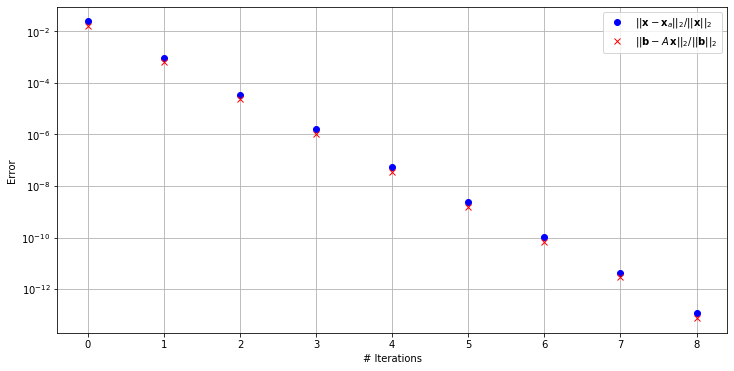

In [11]:
Ni_e = np.arange(err.shape[-1])
Ni_b = np.arange(b_e.shape[-1])
plt.figure(figsize=(12, 6))
plt.plot(Ni_e, err, 'bo', label=r'$||\mathbf{x} - \mathbf{x}_a||_2/||\mathbf{x}||_2$')
plt.plot(Ni_b, b_e, 'rx', label=r'$||\mathbf{b} - A\,\mathbf{x}||_2/||\mathbf{b}||_2$')
plt.yscale('log')
plt.xlabel('# Iterations')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()

## Referencias
* [1] https://github.com/tclaudioe/Scientific-Computing/blob/master/SC1/10_GMRes.ipynb
* [2] https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.gmres.html